In [1]:
# Import neccesary modules
# Set matplotlib to inline mode for the Jupyter notebook visualisations

%matplotlib inline

import rospy
from sensor_msgs.msg import LaserScan
from nav_msgs.srv import GetMap
from nav_msgs.msg import OccupancyGrid

import numpy as np
import matplotlib.pyplot as plt

import numpy as np

import copy
import time
import math

# the map resolution (1 = default)
global resolution
resolution = 1

# Helper method for retrieving the map
def getMap() -> OccupancyGrid:
    """ Loads map from map service """
    # Create service proxy
    get_map = rospy.ServiceProxy('static_map', GetMap)
    # Call service
    recMap = get_map()
    recMap = recMap.map
    resolution = recMap.info.resolution
    # Return
    return recMap

def splitMap(map):
    """ Iterates over the map cells and add each to a corresponding list
        according to whether it is a wall or free space
        Arguments:
        map: 2d list of integers, 
             each a percentage chance of empty or occupied space.
             Indices of each integer = coordinates
    """
    # the arrays to hold the free and wall cells in the map
    global wallPositions
    wallPositions = None
    global freePositions
    freePositions = None
    
    # iteration counters serving as indices for the arrays
    x:int = 0 
    y:int = 0

    # nested loop to go through each cell
    # certainty of occupance is rated 0 - 100
    for row in map:
        for cell in row:
            if cell == 0:
                # add to empty space list
                pos = np.array([[x, y]])
                if freePositions is not None:
                    freePositions = np.vstack((freePositions, pos))
                else:
                    freePositions = pos
            else:
                # add to wall list
                pos = np.array([[x, y]])
                if wallPositions is not None:
                    wallPositions = np.vstack((wallPositions, pos))
                else:
                    wallPositions = pos
            y += 1
        y = 0
        x += 1
    

def laserScanSubCallback(msg):
    """ Loads the laserscan from message """
    # read the message
    ranges = np.array(msg.ranges)
    angle_min = msg.angle_min
    angle_max = msg.angle_max
    increment = msg.angle_increment
    
    angles = np.arange(angle_min, angle_max, 1/len(ranges))
    i = 0

    global scan
    scan = None
    
    for range in ranges:
        x = math.sin(angle_min)*(range + resolution/2)
        y = math.cos(angle_min)*(range + resolution/2)
        pos = np.array([[x, y]])
        angle_min += increment
        if scan is not None:
            scan = np.vstack((scan, pos))
        else:
            scan = pos
        i += 1

laserScanSub = rospy.Subscriber("/scan", LaserScan, laserScanSubCallback)

# Initiate ROS node
rospy.init_node('mazeEscape')
recMap = getMap()

# convert the data to a 2d array (coordinates with occupancy certaincy)
mapData = np.array(recMap.data)
recMap = np.split(mapData, recMap.info.width)

# split the map into free and wall cells
splitMap(recMap)

# wait for a laserscan message
rospy.wait_for_message("/scan", LaserScan, 999999999)

header: 
  seq: 2418
  stamp: 
    secs: 484
    nsecs: 305000000
  frame_id: "base_scan"
angle_min: 0.0
angle_max: 6.28318977355957
angle_increment: 0.017501922324299812
time_increment: 0.0
scan_time: 0.0
range_min: 0.11999999731779099
range_max: 3.5
ranges: [0.6336736679077148, 0.6123672723770142, 0.6146873235702515, 0.5976225137710571, 0.5927507281303406, 0.5876942276954651, 0.5626391768455505, 0.5455147624015808, 0.550642192363739, 0.547690212726593, 0.5241857171058655, 0.5423355102539062, 0.5566216707229614, 0.5269092917442322, 0.5042468309402466, 0.5084822177886963, 0.5058294534683228, 0.4873327314853668, 0.48206794261932373, 0.48378127813339233, 0.47528043389320374, 0.4957185685634613, 0.4613547623157501, 0.4621219038963318, 0.48811814188957214, 0.442392498254776, 0.4641305208206177, 0.474202424287796, 0.4561923146247864, 0.44668957591056824, 0.4531477093696594, 0.43650728464126587, 0.44155293703079224, 0.44222572445869446, 0.43959152698516846, 0.4360447824001312, 0.442676782608

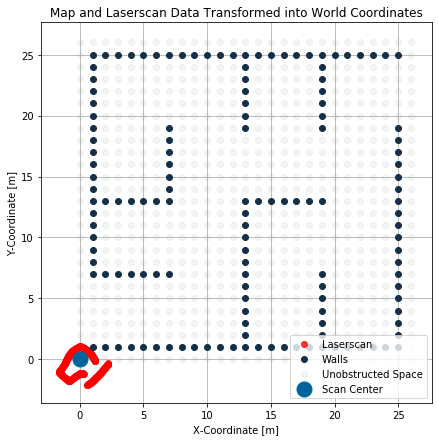

In [2]:
# Store colours matching UAS TW colour scheme as dict 
colourScheme = {
    "darkblue": "#143049",
    "twblue": "#00649C",
    "lightblue": "#8DA3B3",
    "lightgrey": "#CBC0D5",
    "twgrey": "#72777A"
}

## Visualise transformed maze and scans
# Create single figure
plt.rcParams['figure.figsize'] = [7, 7]
fig, ax = plt.subplots()

# Plot data as points (=scatterplot) and label accordingly. The colours are to look nice with UAS TW colours
ax.scatter(scan[:,1], scan[:,0], c="r", alpha=0.8, label="Laserscan")
ax.scatter(wallPositions[:,1], wallPositions[:,0], c=colourScheme["darkblue"], alpha=1.0, s=6**2, label="Walls")
ax.scatter(freePositions[:,1], freePositions[:,0], c=colourScheme["twgrey"], alpha=0.08, s=6**2, label="Unobstructed Space")
ax.scatter([0], [0], c=colourScheme["twblue"], s=15**2, label="Scan Center")

# Set axes labels and figure title
ax.set_xlabel("X-Coordinate [m]")
ax.set_ylabel("Y-Coordinate [m]")
ax.set_title("Map and Laserscan Data Transformed into World Coordinates")

# Set grid to only plot each metre
ax.set_xticks = [-1, 0, 1, 2, 3, 4 ]
ax.set_yticks = [-1, 0, 1, 2, 3, 4 ]

# Move grid behind points
ax.set_axisbelow(True)
ax.grid()

# Add labels
ax.legend()

# Show plot
plt.show()